In [8]:
import random
import string
import re
import numpy as np

from string import punctuation
import pandas as pd

from collections import Counter
from wordcloud import WordCloud

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Embedding, Dense, LSTM, Dropout, TimeDistributed, RepeatVector
from collections import Counter
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.losses import SparseCategoricalCrossentropy

In [10]:
# Load data and set labels
data = pd.read_csv("/content/eng_-french.csv")

# Display dimensions of dataframe
print(data.shape)
print(data.info())

print("-----------------------------------------------------------------------")
# Display 10 random samples
print(data.head())

(175621, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175621 entries, 0 to 175620
Data columns (total 2 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   English words/sentences  175621 non-null  object
 1   French words/sentences   175621 non-null  object
dtypes: object(2)
memory usage: 2.7+ MB
None
-----------------------------------------------------------------------
  English words/sentences French words/sentences
0                     Hi.                 Salut!
1                    Run!                Cours !
2                    Run!               Courez !
3                    Who?                  Qui ?
4                    Wow!             Ça alors !


In [11]:
# Separating the English and French datasets
eng = data['English words/sentences']
fra = data['French words/sentences']

In [12]:
eng_word_counter = Counter([word for sentence in eng for word in sentence.split()])
print("Total count of English words:",len([word for sentence in eng for word in sentence.split()]))
print("Count of distinct English words:",len(eng_word_counter))
print("10 most common English words:",list(zip(*eng_word_counter.most_common(10)))[0])

Total count of English words: 1082098
Count of distinct English words: 27393
10 most common English words: ('I', 'to', 'you', 'the', 'a', 'is', 'Tom', 'of', 'in', 'have')


In [13]:
fra_word_counter = Counter([word for sentence in fra for word in sentence.split()])
print("Total count of French words:",len([word for sentence in fra for word in sentence.split()]))
print("Count of distinct French words:",len(fra_word_counter))
print("10 most common French words:",list(zip(*fra_word_counter.most_common(10)))[0])

Total count of French words: 1177832
Count of distinct French words: 44918
10 most common French words: ('de', 'Je', '?', 'pas', 'que', 'à', 'ne', 'la', 'le', 'Il')


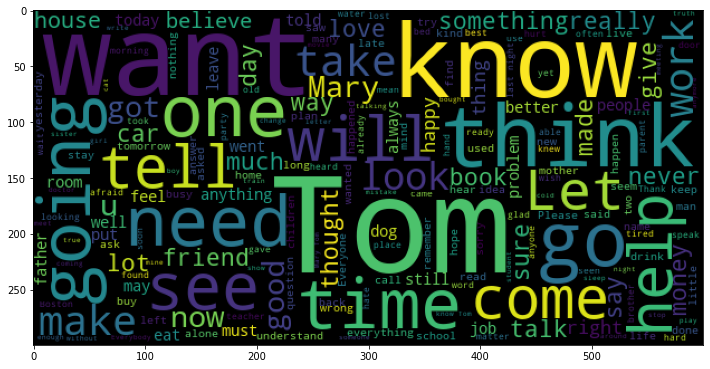

In [14]:
plt.figure(figsize=(12,8))
wc = WordCloud(width=600,height=300).generate(' '.join(eng))
plt.imshow(wc)
plt.show();

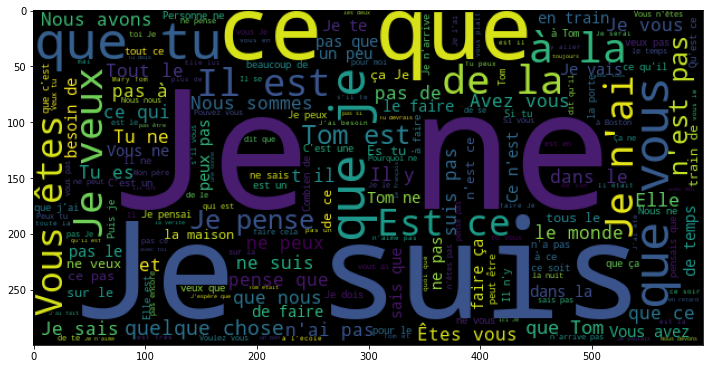

In [15]:
plt.figure(figsize=(12,8))
wc = WordCloud(width=600,height=300).generate(' '.join(fra))
plt.imshow(wc)
plt.show();

In [16]:
def word_count(line):
  return len(line.split())

TEXT TO SEQUENCE CONVERSION(WORD TO INDEX MAPPING

1.CONVERT THE SENTENCES INTO WORDS
(THOSE WORDS IN NUMBERS)

2.EVERY SENTENCE SHOULD BE OF THE SAME LENGTH( THIS PADDING)


In [17]:
#Function to build a tokenizer,fit on texts
def create_tokenizer(sentences):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(sentences)
  return tokenizer

In [18]:
def max_sentence_length(lines):
  return max(len(sentence.split()) for sentence in lines)

In [19]:
#encode and pad sequence
def encode_sequences(tokenizer,sentences,max_sent_len):
  text_to_seq = tokenizer.texts_to_sequences(sentences) # encode sequences with integers
  text_pad_seq = pad_sequences(text_to_seq,maxlen=max_sent_len,padding='post') # pad sequences with 0
  return text_pad_seq


In [20]:
# Prepare English tokenizer
eng_tokenizer = create_tokenizer(eng)
eng_vocab_size = len(eng_tokenizer.word_index) + 1  # start counting from 1,since 0 is preserved for padding
max_eng_sent_len = max_sentence_length(eng)
print("English vocabulary size:", eng_vocab_size)
print("Maximum length of English sentences:", max_eng_sent_len)

English vocabulary size: 14532
Maximum length of English sentences: 44


In [21]:
# Prepare French tokenizer
fra_tokenizer = create_tokenizer(fra)
fra_vocab_size = len(fra_tokenizer.word_index) + 1
max_fra_sent_len = max_sentence_length(fra)
print("French vocabulary size:", fra_vocab_size)
print("Maximum length of French sentences:", max_fra_sent_len)

French vocabulary size: 30661
Maximum length of French sentences: 55


In [22]:
max_eng_sent_len = 22
max_fra_sent_len = 22

In [23]:
# Perform encoding of sequences
X = encode_sequences(eng_tokenizer,eng,max_eng_sent_len)
y = encode_sequences(fra_tokenizer,fra,max_fra_sent_len)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15,shuffle=True,random_state=101)

Define our SeqSeq Model architecture:

In [25]:
def create_model(src_vocab_size,dest_vocab_size,src_timesteps,dest_timesteps,no_units):
  model = Sequential()
  model.add(Embedding(src_vocab_size,no_units,input_length=src_timesteps,mask_zero=True))
  model.add(LSTM(no_units))
  model.add(RepeatVector(dest_timesteps)) # repeated the process 22 times
  model.add(LSTM(no_units,return_sequences=True))
  model.add(TimeDistributed(Dense(1024,activation='relu')))
  model.add(Dropout(0.2))
  model.add(TimeDistributed(Dense(dest_vocab_size,activation='softmax'))) #vob of french
  return model

In [26]:
model = create_model(eng_vocab_size,fra_vocab_size,max_eng_sent_len,max_fra_sent_len,512) #30661 for french, using 512 neurons
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 22, 512)           7440384   
                                                                 
 lstm (LSTM)                 (None, 512)               2099200   
                                                                 
 repeat_vector (RepeatVector  (None, 22, 512)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 22, 512)           2099200   
                                                                 
 time_distributed (TimeDistr  (None, 22, 1024)         525312    
 ibuted)                                                         
                                                                 
 dropout (Dropout)           (None, 22, 1024)          0

In [27]:
model.compile(loss=SparseCategoricalCrossentropy(),optimizer='rmsprop',metrics='accuracy')

In [28]:
es = EarlyStopping(monitor='val_accuracy',patience=5,mode='max',verbose=1)
lr = ReduceLROnPlateau(monitor='val_accuracy',patience=3,mode='max',verbose=1,factor=0.1,min_lr=0.001)

In [29]:
r = model.fit(X_train,
              y_train.reshape(y_train.shape[0],y_train.shape[1],1),
              epochs=6,
              batch_size=512,
              callbacks=[es,lr],
              validation_data=(X_test,y_test.reshape(y_test.shape[0],y_test.shape[1],1)))

Epoch 1/6
292/292 [==============================] - 309s 1s/step - loss: 2.2650 - accuracy: 0.7104 - val_loss: 1.9614 - val_accuracy: 0.7253 - lr: 0.0010
Epoch 2/6
292/292 [==============================] - 299s 1s/step - loss: 1.8229 - accuracy: 0.7361 - val_loss: 1.7190 - val_accuracy: 0.7453 - lr: 0.0010
Epoch 3/6
292/292 [==============================] - 297s 1s/step - loss: 1.6428 - accuracy: 0.7531 - val_loss: 1.5747 - val_accuracy: 0.7592 - lr: 0.0010
Epoch 4/6
292/292 [==============================] - 297s 1s/step - loss: 1.4958 - accuracy: 0.7654 - val_loss: 1.4608 - val_accuracy: 0.7689 - lr: 0.0010
Epoch 5/6
292/292 [==============================] - 296s 1s/step - loss: 1.3695 - accuracy: 0.7753 - val_loss: 1.4101 - val_accuracy: 0.7765 - lr: 0.0010
Epoch 6/6
292/292 [==============================] - 295s 1s/step - loss: 1.2661 - accuracy: 0.7836 - val_loss: 1.2677 - val_accuracy: 0.7856 - lr: 0.0010


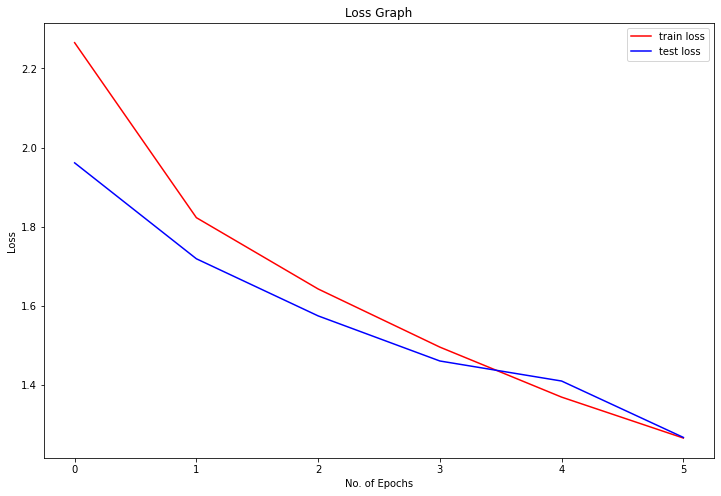

In [30]:
plt.figure(figsize=(12,8))
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

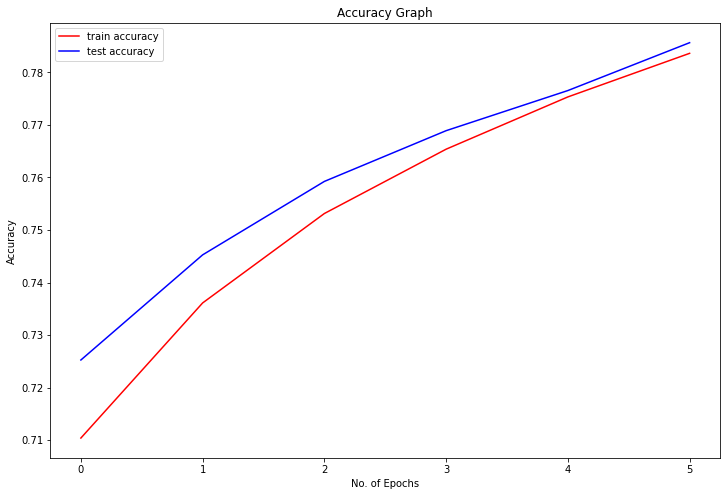

In [31]:
plt.figure(figsize=(12,8))
plt.plot(r.history['accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_accuracy'],'b',label='test accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

In [32]:
model.evaluate(X_test,y_test.reshape(y_test.shape[0],y_test.shape[1],1))

824/824 [==============================] - 33s 40ms/step - loss: 1.2677 - accuracy: 0.7856


[1.267655372619629, 0.7856351733207703]